In [ ]:
"""
created by:
Nick Roseveare, Nov 2018, nicholasroseveare AT gmail.com
"""

## NOTES
Starting with the dataset available here: https://archive.ics.uci.edu/ml/datasets/EEG+Database, can ID the major class? How about the individual subjects?

Looking at this reference on EEG: https://en.wikipedia.org/wiki/Electroencephalography
a cursory review shows that Beta and Gamma waves 16-32Hz, and >32Hz are most related to active thinking, and even short-term memory/pattern matching tasks.

## Existing open-source work
   * ARL EEG ML models https://github.com/vlawhern/arl-eegmodels with paper http://iopscience.iop.org/article/10.1088/1741-2552/aae5d8 (and others)
   * Brain-computer interface model, perhaps possible to adapt to more simplistic class id problem. This paper https://arxiv.org/abs/1611.08024.

## Things to try
   * Based on the above we could try taking coefficients from a FFT or power spectral density
   * Since there are a lot of possible native 'features', we might try a data reduction technique like PCA to exact combinations of feature that correspond to 'designed' features that contain more relevant information about the underlying signal
   * Similarly, we can use correlation analysis (and/or PCA) to find features correlated for one group that are more or less uncorrelated for the other group, thus, keeping these specific pairs should provide some discriminating features
   * Along with a reduction in the features considered useful, we can try a naive Bayes with a few moment statistics as inputs 
   * Leaning toward PCA-reduced or correlation-based sub-selection of frequency/PSD features from individual sensors combined via PCA dominant eigen-vectors; 
   * Can also try with manually selected frequency features based on Gamma and Beta wave frequencies
   * create encoder for one-hot on the match types (or just create three models), use 'alcoholic' or 'subject' as label

### Basic Approaches
   * standardize inputs: (value - (max-min)/2)/(max-min)
   * NN (basic, fully connected, 3 layers, allow validation to tune size)
   * Random forest
   * SVM
   * robust covariance
   * ensemble of a few of the above

    
### To plot
   * PSD feature outputs
   * subsets of features for alcoholic / control on the Beta/Gamma wave feature frequencies
   * loss and various accuracy metrics on training and test
     


In [1]:
from eeg_project.read_data import (import_eeg_file, GetClassId,
    my_read_eeg_generic, senlist_known, match_types, SAMP_FREQ,
    accumulate_subject_file_list, PSD_on_row_data, pass_through, zero, PSD_on_row_data, fft_on_row_data,
    eeg_half_half_alcoholic_all_subjects_obj_40, eeg_half_half_alcoholic_all_subjects_obj_100,
    eeg_half_half_alcoholic_all_subjects_match_100, eeg_half_half_alcoholic_all_subjects_nomatch_100)
from eeg_project.plot_data import (plot_data_subject_dirs)

import numpy as np
import pandas as pd
import os

from six import text_type
import gzip, bz2
import tqdm 
from collections import defaultdict

from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D
# import ipywidgets as widgets
from IPython.display import display, clear_output
# %matplotlib notebook


In [ ]:
# data_dir = 'small_data_set'
# data_dirs = [f'./{data_dir}/SMNI_CMI_TRAIN', f'./{data_dir}/SMNI_CMI_TEST']

files processed: 100%|█████████▉| 199/200 [00:24<00:00,  8.18it/s]

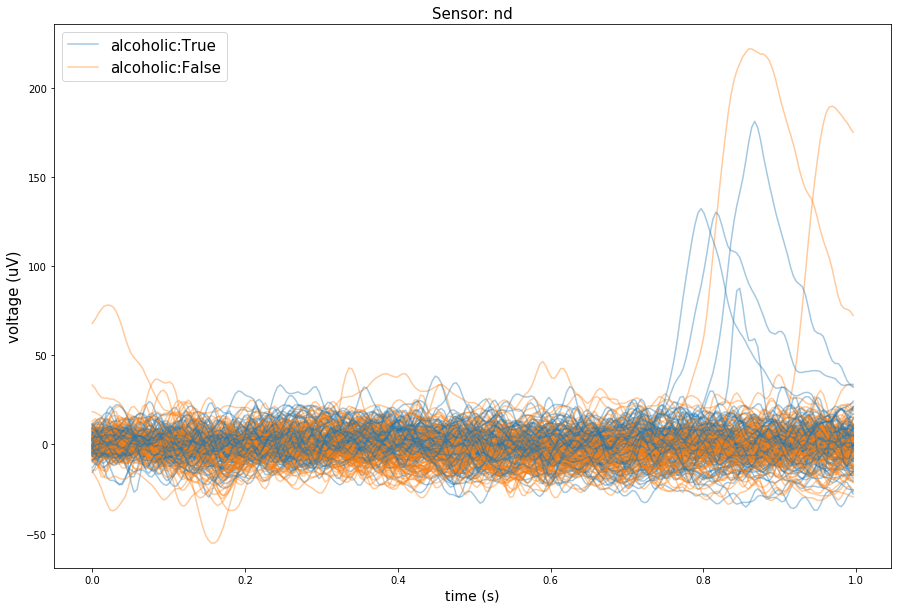

unique entries in metadata from file accumulation
   subject: {'co2a0000377', 'co2c0000345', 'co2c0000346', 'co2a0000378', 'co2c0000344', 'co2c0000338', 'co2c0000337', 'co2c0000347', 'co2c0000342', 'co2c0000341', 'co2c0000339', 'co2a0000369', 'co2a0000365', 'co2a0000364', 'co2a0000368', 'co2a0000375', 'co2a0000370', 'co2c0000340', 'co2a0000371', 'co2a0000372'}
   trial: {0, 32, 2, 34, 4, 36, 6, 38, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30}
   is_test_set: {0}
   alcoholic: {False, True}
   match: {'obj'}
   err: {False}


In [2]:
# plot single data samples
plots = dict(overlap=0, grid=0, threed=0, all_data_traces='nd')
flist = plot_data_subject_dirs(#data_dirs, 
#                        file_list=eeg_half_half_alcoholic_all_subjects_obj_40,
                       plots=plots,
                       labelby='alcoholic',
                       limitby=dict(match='obj'),
                       transparency=.4,
                       figsize=(15, 10),
                       force_axes_same_scale=False,
                       limit_mult_files=(200, [('subject', 20), ('alcoholic', 2)]),
                       debug=1)

/Users/nick/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


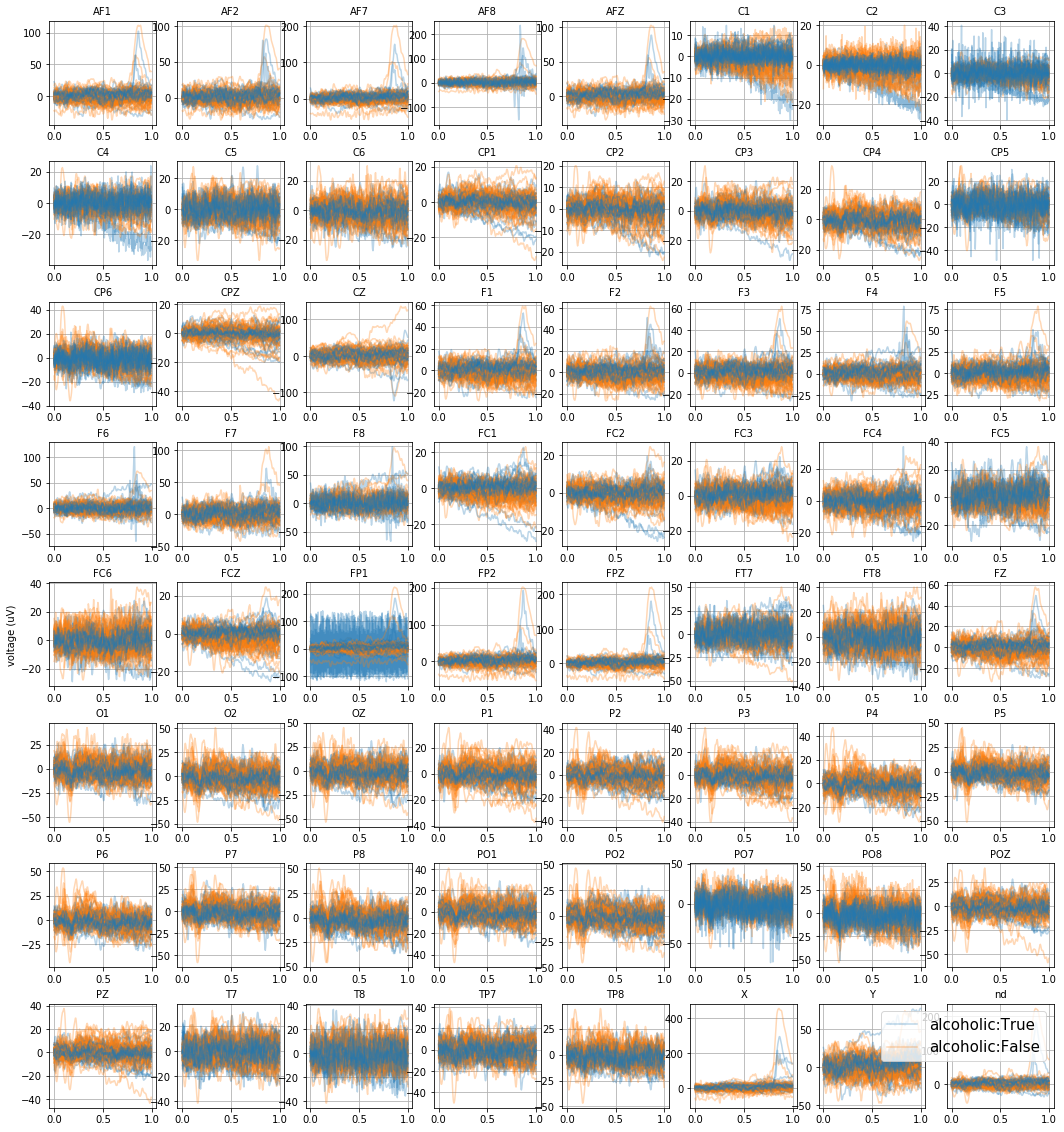

In [2]:
# plot overlaying traces for multiple subjects
plots = dict(overlap=0, grid=1, threed=0, all_traces_one_sensor=None)
flist = plot_data_subject_dirs(#data_dirs, 
   file_list=eeg_half_half_alcoholic_all_subjects_obj_100, 
   plots=dict(grid='square', all_data_traces=True),
   labelby='alcoholic',
   limitby=dict(match='obj'),
   transparency=.3,
   figsize=(18, 20),
   force_axes_same_scale=False,
#    yscale='log',
#    limit_mult_files=(40, [('subject', 20), ('alcoholic', 2)]),
   debug=0)

files processed:   1%|          | 1/100 [00:01<02:12,  1.33s/it]/Users/nick/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
files processed:  99%|█████████▉| 99/100 [00:37<00:00,  2.61it/s]

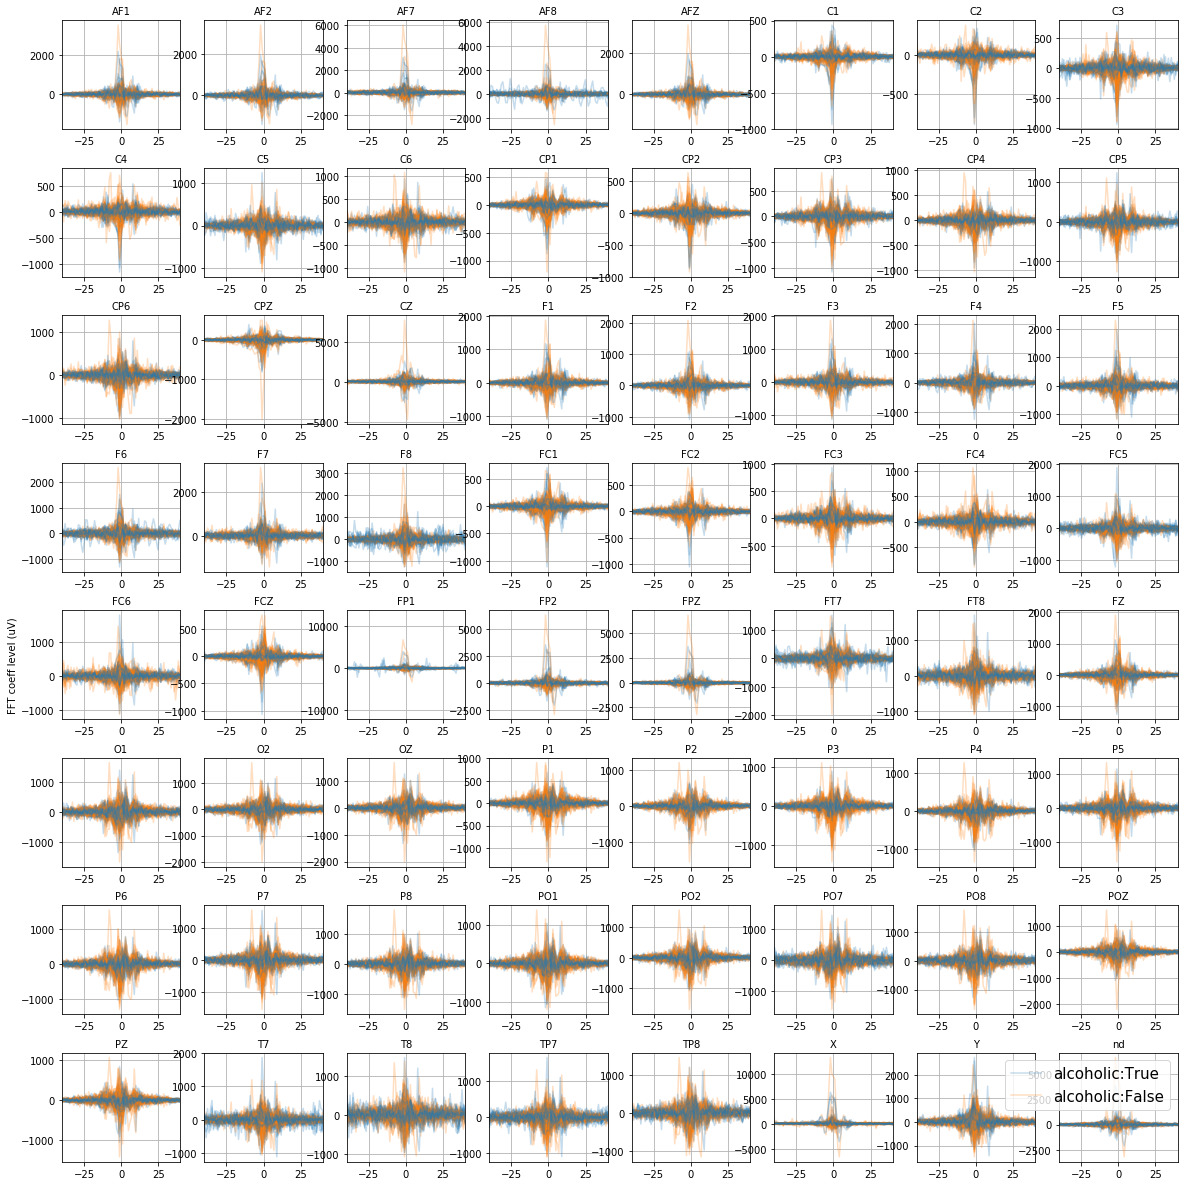

unique entries in metadata from file accumulation
   subject: {'co2a0000368', 'co2c0000339', 'co2c0000342', 'co2c0000346', 'co2c0000337', 'co2a0000369', 'co2a0000371', 'co2c0000338', 'co2a0000364', 'co2a0000377', 'co2a0000372', 'co2c0000347', 'co2c0000341', 'co2c0000344', 'co2c0000345', 'co2a0000370', 'co2a0000378', 'co2a0000365', 'co2a0000375', 'co2c0000340'}
   trial: {0, 32, 2, 34, 4, 36, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30}
   is_test_set: {0}
   alcoholic: {False, True}
   match: {'obj'}
   err: {False}


In [3]:
files = plot_data_subject_dirs(#data_dirs, 
   file_list=eeg_half_half_alcoholic_all_subjects_obj_100,
   plots=dict(grid='square', all_data_traces=True),
   yscale='linear',
   labelby='alcoholic',
   limitby=dict(match='obj'),
   transparency=.25,
   figsize=(20, 21),
   force_axes_same_scale=False,
#    limit_mult_files=(40, [('subject', 20), ('alcoholic', 2)]),
   xrange=(-40, 40),
#    yrange=(-1, 1500),
   debug=1,
   process_data=fft_on_row_data)

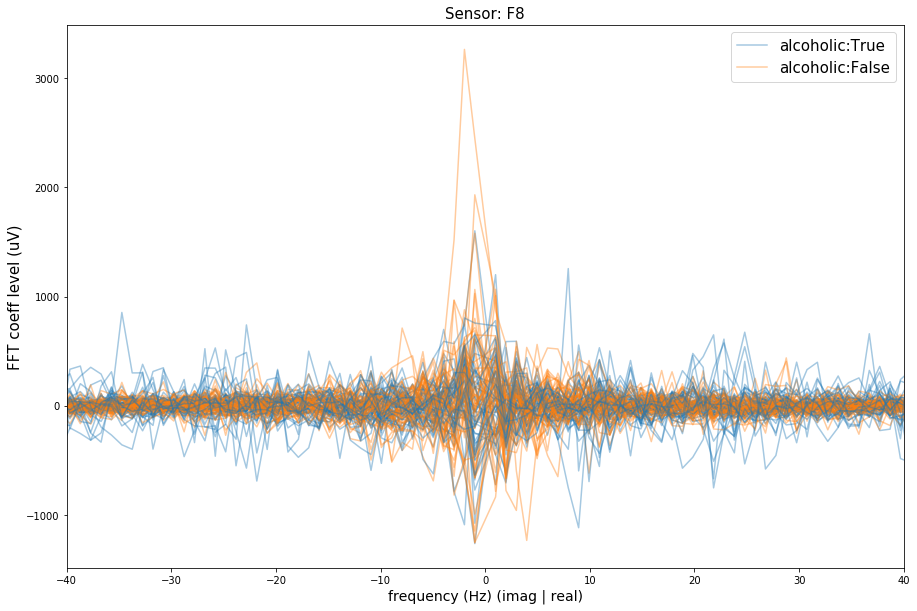

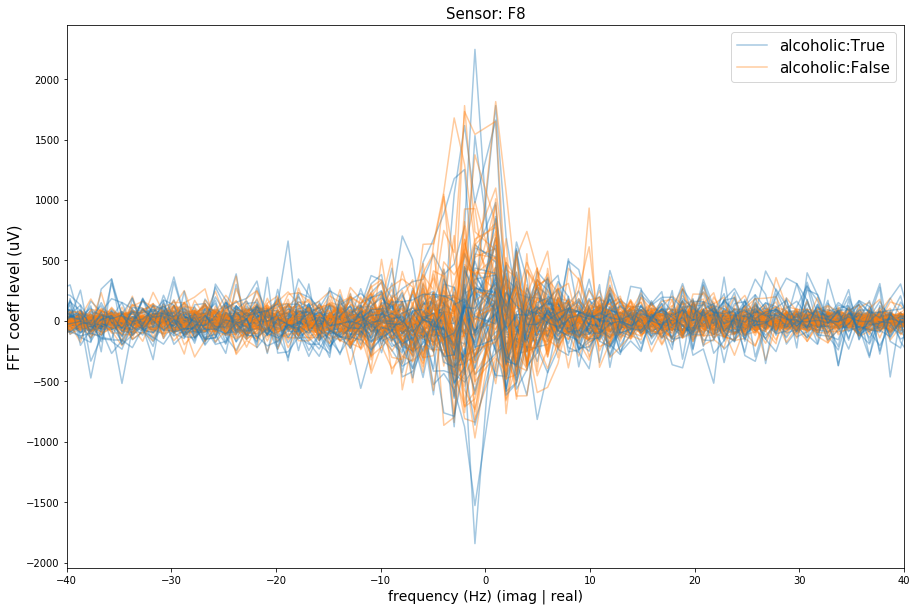

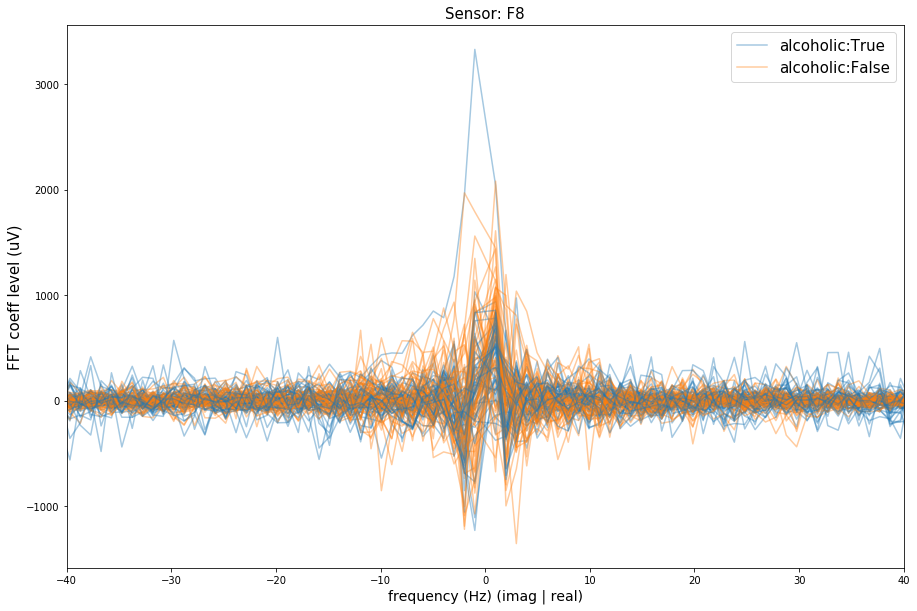

In [6]:
# plot single sensor FFT data samples
plots = dict(overlap=0, grid=0, threed=0, all_data_traces='F8')
flist = plot_data_subject_dirs(#data_dirs, 
   file_list=eeg_half_half_alcoholic_all_subjects_obj_100,
   plots=plots,
   labelby='alcoholic',
#    limitby=dict(match='obj'),
   transparency=.4,
   figsize=(15, 10),
   xrange=(-40, 40),        
   force_axes_same_scale=False,
#    limit_mult_files=(40, [('subject', 20), ('alcoholic', 2)]),
   debug=0,
   process_data=fft_on_row_data)

flist = plot_data_subject_dirs(#data_dirs, 
   file_list=eeg_half_half_alcoholic_all_subjects_nomatch_100,
   plots=plots,
   labelby='alcoholic',
#    limitby=dict(match='obj'),
   transparency=.4,
   figsize=(15, 10),
   xrange=(-40, 40),        
   force_axes_same_scale=False,
#    limit_mult_files=(40, [('subject', 20), ('alcoholic', 2)]),
   debug=0,
   process_data=fft_on_row_data)

flist = plot_data_subject_dirs(#data_dirs, 
   file_list=eeg_half_half_alcoholic_all_subjects_match_100,
   plots=plots,
   labelby='alcoholic',
#    limitby=dict(match='obj'),
   transparency=.4,
   figsize=(15, 10),
   xrange=(-40, 40),        
   force_axes_same_scale=False,
#    limit_mult_files=(40, [('subject', 20), ('alcoholic', 2)]),
   debug=0,
   process_data=fft_on_row_data)

/Users/nick/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


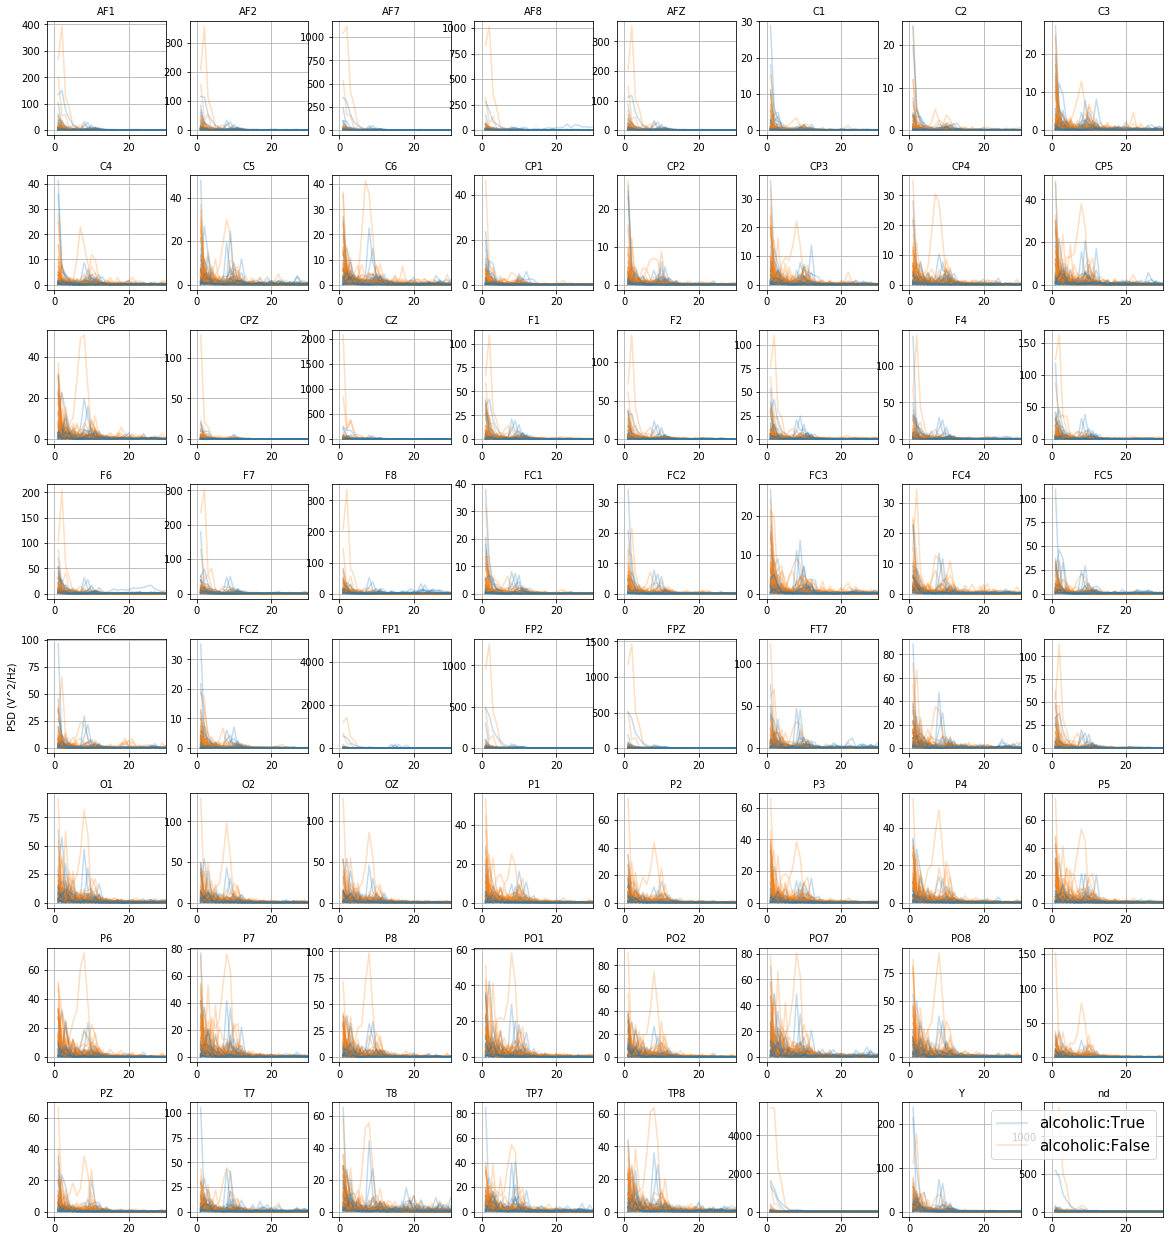

In [8]:
files = plot_data_subject_dirs(#data_dirs, 
                       file_list=eeg_half_half_alcoholic_all_subjects_obj_100,
                       plots=dict(grid='square', all_data_traces=True),
                       yscale='linear',
                       labelby='alcoholic',
                       limitby=dict(match='obj'),
                       transparency=.25,
                       figsize=(20, 22),
                       xrange=(-2, 30),        
                       force_axes_same_scale=False,
#                        limit_mult_files=(40, [('subject', 20), ('alcoholic', 2)]),
                       debug=0,
                       process_data=PSD_on_row_data)


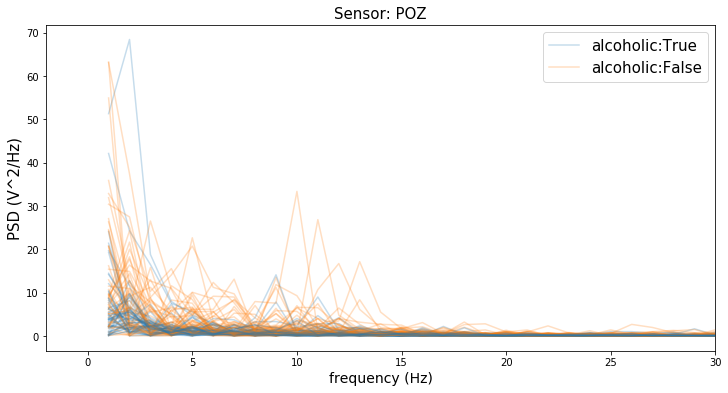

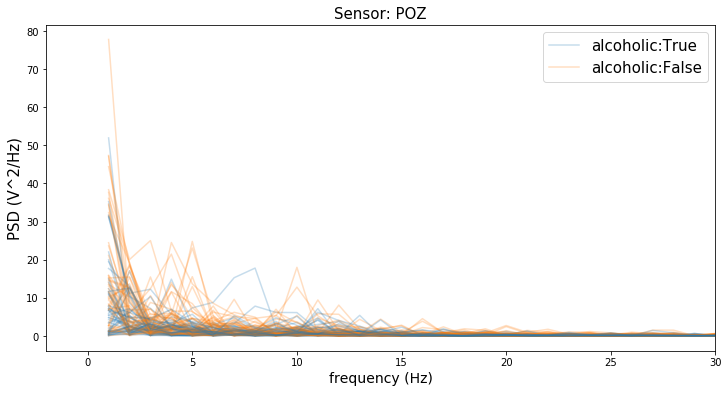

In [9]:
files = plot_data_subject_dirs(#data_dirs, 
                       file_list=eeg_half_half_alcoholic_all_subjects_match_100,
                       plots=dict(overlap=True, all_data_traces='POZ'),
                       yscale='linear',
                       labelby='alcoholic',
#                        limitby=dict(match='match'),
                       transparency=.25,
                       figsize=(12, 6),
                       xrange=(-2, 30),        
                       force_axes_same_scale=False,
                       debug=0,
                       process_data=PSD_on_row_data)

files = plot_data_subject_dirs(#data_dirs, 
                       file_list=eeg_half_half_alcoholic_all_subjects_nomatch_100,
                       plots=dict(overlap=True, all_data_traces='POZ'),
                       yscale='linear',
                       labelby='alcoholic',
#                        limitby=dict(match='nomatch'),
                       transparency=.25,
                       figsize=(12, 6),
                       xrange=(-2, 30),        
                       force_axes_same_scale=False,
                       debug=0,
                       process_data=PSD_on_row_data)

In [ ]:
file_list, unq_items, total = accumulate_subject_file_list(data_dirs, limitby=dict(match='obj'),
        limit_mult_files=(100, [('subject', 20), ('alcoholic', 2)]), df_type='wide', debug=1)
unq_items

In [ ]:
df, info = my_read_eeg_generic(
    './small_data_set/SMNI_CMI_TRAIN/co2a0000364/co2a0000364.rd.002.gz', 
    orig_tt_indic=0)
print(info)

# fft_on_row_data(df.ind df.Z)
x, Z, xlabel, ylabel = fft_on_row_data(df.index.values, df.values, 'time', 'voltage')
x.shape, Z.shape

In [ ]:
# subject_data = pd.DataFrame({})
# frame_list = []
# for file in half_half_alcoholic_all_subjects_40:
#     frame, info = my_read_eeg_generic(file, orig_tt_indic=('test' in file))
# #     frame = pd.read_csv(file, names=columns)
#     frame_list.append(frame)
    
# subject_data = pd.concat(frame_list, axis=0, join_axes=[frame.index, frame.columns])  # , ignore_index=True)
                                  
# subject_data